# Walmart : predict weekly sales

Le service marketing de Walmart nous demande de construire un modèle d'apprentissage automatique capable d'estimer les ventes hebdomadaires dans leurs magasins. Un tel modèle les aiderait à mieux comprendre comment les ventes sont influencées par les indicateurs économiques et pourraient être utilisées pour planifier de futures campagnes marketing.

# Import libraries

In [117]:
!pip install plotly==5.0.0 -q
!pip install missingno -q
%matplotlib inline 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sklearn
from numpy import arange
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,LeaveOneOut
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,mean_squared_error ,r2_score,mean_absolute_error
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.graph_objects as go, plotly.express as px, plotly.io as pio
import statsmodels.api as st
import matplotlib.pyplot as plt
import plotly.express as px

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe_connected"

In [118]:
data= pd.read_csv("Walmart_Store_sales.csv")
print(data.shape)
data.head()

(150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


**Features explanation**
- Store: Identifiant de chaque magasin Walmart
- Date: La date du jour où cette observation a été prise
- Weekly_Sales: Les ventes enregistrées à ce jour
- Holiday_Flag: Une valeur booléenne représentant un jour férié ou non
- Temperature:Température de la région pendant la journée
- Fuel_Price: Prix du carburant dans cette région pendant la journée
- CPI: Indice des prix à la consommation pendant la journée
- Unemployment: Le taux de chômage en journée dans la région du magasin

# EDA and data preprocessing

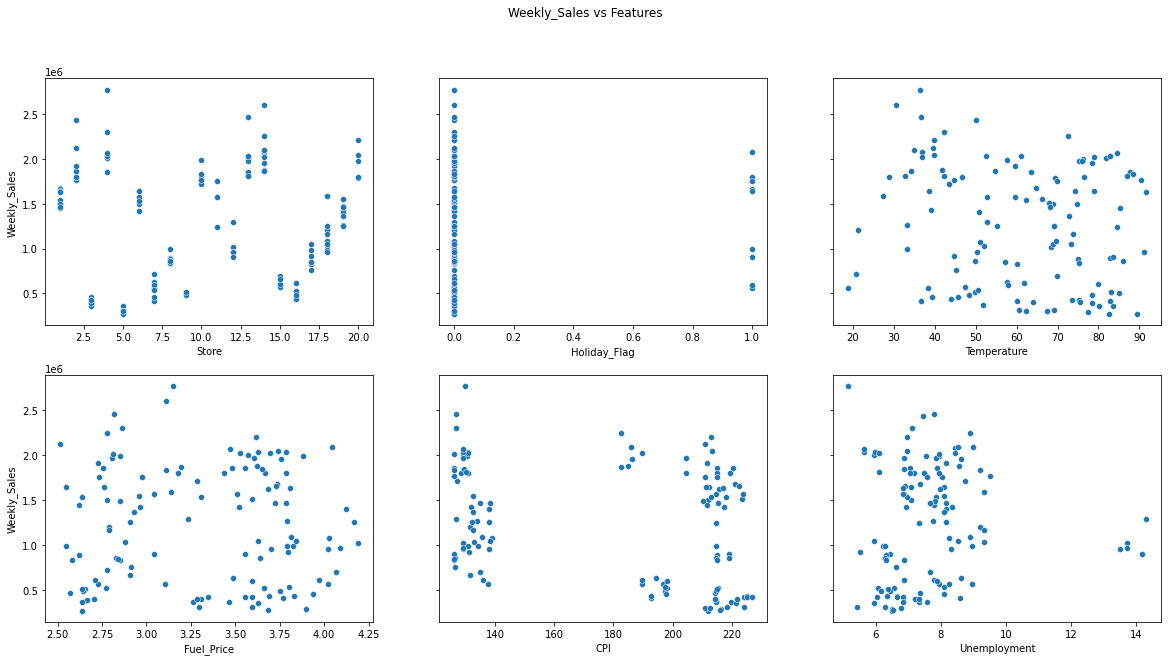

In [119]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig.suptitle("Weekly_Sales vs Features")

sns.scatterplot(ax=axes[0, 0], x="Store", y="Weekly_Sales", data=data)
sns.scatterplot(ax=axes[0, 1], x="Holiday_Flag", y="Weekly_Sales", data=data)
sns.scatterplot(ax=axes[0, 2], x="Temperature", y="Weekly_Sales", data=data)
sns.scatterplot(ax=axes[1, 0], x="Fuel_Price", y="Weekly_Sales", data=data)
sns.scatterplot(ax=axes[1, 1], x="CPI", y="Weekly_Sales", data=data)
sns.scatterplot(ax=axes[1, 2], x="Unemployment", y="Weekly_Sales", data=data);

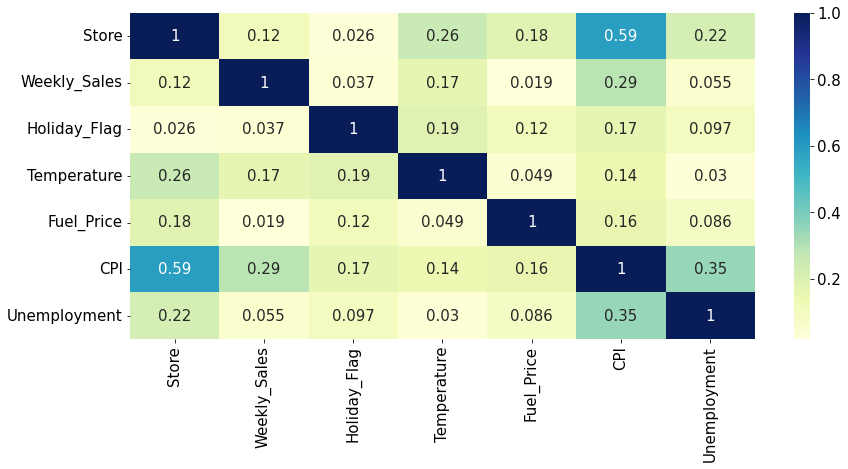

In [120]:
corr = data.corr()
corr = corr.abs()
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 15})

sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()


- Store, Temperature, Fuel_Price, CPI semblent bien répartis
- plus de ventes lorsque Holidays_Flag = 0
- plus de ventes quand le chômage est faible
- D'apres les graphes et la matrice de corrélation, il n'y a pas de forte correlation de entre les variables

In [121]:
print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

- Toutes les colonnes ont très peu de valeurs manquantes.

In [122]:
# drop the lines in the dataset for which the value in Weekly_Sales is missing
mask = ~data.Weekly_Sales.isnull()
data = data.loc[mask, :]
data = data.reset_index(drop=True)
print(data.shape)

# drop lines containing invalid values or outliers [Xˉ−3σ, Xˉ+3σ]
list_col = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for elt in list_col:
    mask = (data[elt] < data[elt].mean() + 3*data[elt].std()) & (data[elt] > data[elt].mean() - 3*data[elt].std())
    data = data.loc[mask, :]
#Nous supprimons les valeurs aberrantes qui ne tombent pas dans l'intervalle : [𝑋¯−3𝜎,𝑋¯+3𝜎] .
#En machine learning toutes les valeurs en dehors sont des outliers. 
#On les supprime afin d'éviter de fausser l'apprentissage.
print(data.shape)

# drop the lines in the dataset for which the value in Date is missing
mask = ~data.Date.isnull()
data = data.loc[mask, :]
data = data.reset_index(drop=True)
print(data.shape)

# create usable features from the Date column
# Extract features from Date column
data.Date = pd.to_datetime(data.Date, format="%d-%m-%Y")
data["Year"] = data.Date.dt.year
data["Month"] = data.Date.dt.month
data["Day"] = data.Date.dt.day
data["DayOfWeek"] = data.Date.dt.dayofweek
print(data.shape)

# drop Date column
data.drop(["Date"], axis=1, inplace=True)
print(data.shape)
print(100*data.isnull().sum()/data.shape[0])
data.head()

(136, 8)
(90, 8)
(80, 8)
(80, 12)
(80, 11)
Store            0.00
Weekly_Sales     0.00
Holiday_Flag    11.25
Temperature      0.00
Fuel_Price       0.00
CPI              0.00
Unemployment     0.00
Year             0.00
Month            0.00
Day              0.00
DayOfWeek        0.00
dtype: float64


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
2,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
3,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
4,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,4


Text(0.5, 1.0, 'Moyenne des ventes par mois et par années')

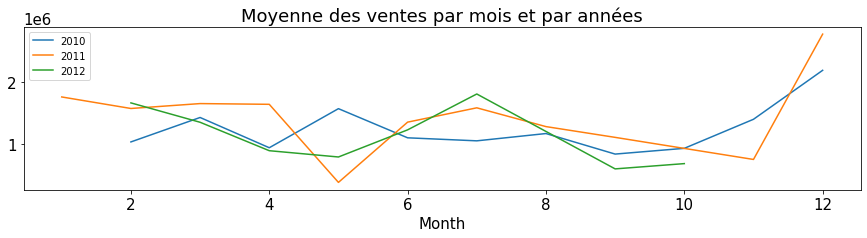

In [123]:
plt.figure(figsize=(15,3))
data[data['Year']==2010].groupby('Month')['Weekly_Sales'].mean().plot()
data[data['Year']==2011].groupby('Month')['Weekly_Sales'].mean().plot()
data[data['Year']==2012].groupby('Month')['Weekly_Sales'].mean().plot()
plt.legend(['2010', '2011', '2012'], fontsize=10)
plt.title('Moyenne des ventes par mois et par années', fontsize=18)

- Ce graphique nous permet de visualiser les ventes sur 3 années consécutives et met en avant les pîques d'affluences communs. Il nous permet également de constater des différences de résultats en fonction des années pouvant être liés à plusieurs facteurs.

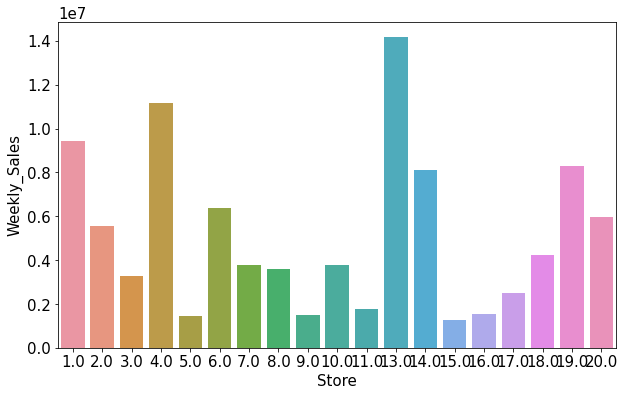

In [124]:
temp =data.groupby('Store')['Weekly_Sales'].sum().reset_index().sort_values('Weekly_Sales', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=temp, x='Store', y='Weekly_Sales')
plt.show()

- Certains magasins fonctionnent bien mieux que d'autres.
- Il pourrait être intéressant d'avoir plus de données sur les magasins : leur taille, leur emplacement, etc.

# Régression linéaire

In [125]:
# sépare nos variables Y et X
features_list = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
target_variable = "Weekly_Sales"

X = data.loc[:,features_list]
Y = data.loc[:,target_variable]

# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0)
# convertir les Datafram en numpy avant d'utiliser scikit-learn
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

# random_state: to control the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.


In [126]:
# Create pipeline for numerical features
numeric_features = [2,3,4,5]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns' mean
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_features = [0, 1]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first'))]) # first column will be dropped to avoid creating correlations between features

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set on utilise .todense 
# pour éviter de transformer notre variable en sparce matrix
X_train = preprocessor.fit_transform(X_train)
#X_train = X_train.todense()
#Preprocessings on test set
X_test = preprocessor.transform(X_test)
#X_test = X_test.todense()

# Encoding categorical features and standardizing numerical features

# Train model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Predictions on training set
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
 # calcule des métriques d'évaluation 
coef = regressor.coef_
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100
SST = np.sum(np.square(Y_train- np.mean(Y_train)))
SSE = np.sum(np.square(regressor.predict(X_train) - np.mean(Y_train)))
SSR = np.sum(np.square(Y_train - regressor.predict(X_train)))
R_2 = 1 - SSR/SST
R_2_alt = regressor.score(X_train,Y_train) 
n = X.shape[0]
p = X.shape[1]
R_2_adj = 1 - (n-1)/(n-p-1)*(1-R_2)

# les métriques d'évaluation
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)
print("\n")



R2 score on training set :  0.9766794787893393
R2 score on test set :  0.9649502268607824


root mean square error : 102886.25773857113
mean absolute percentage error : 8.320353337447028




- On constate que nous avons un très bon score sur le test et sur le train qui est de 96%. Notre model arrive donc à bien prédire notre variable cible. On constate également que notre mean absolute pourcentage error estime la valeur d'erreur dans les prédictions et celle-ci est de 8,32% soit 102 886 dollars sur nos Weekly_Sales.

# Fight overfitting

**Ridge**

In [127]:
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

params = {
    'alpha': [0.001,0.01,0.04,0.05, 0.2, 0.3, 0.4,0.7]}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) #verbose = 2 pour voir l'entrainement pour chaques param

gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

# Predictions on training set
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)
print("\n")
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)


The cross-validated R2-score is :  0.6240987254730223
The standard deviation is :  0.2160507933299736
Best hyperparameters :  {'alpha': 0.001}
Best R2 score :  0.7833283477035685


R2 score on training set :  0.9741532739583934
R2 score on test set :  0.9674639979973626


root mean square error : 108315.60117808777
mean absolute percentage error : 8.186004347520603


**Lasso** 

In [128]:
reg = LassoCV(cv=3, alphas=None)
reg.fit(X_train,Y_train)

Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)
#print('montant de la pénalisation choisi:',reg.alpha_)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)

features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
num_var = ['Temperature','Fuel_Price','CPI','Unemployment']
Z = features + num_var
Z = pd.DataFrame(Z) 
coef = pd.DataFrame(reg.coef_,columns=['coef'])
coeff = pd.concat([Z,coef],axis=1)
coeff.groupby(['coef']).sort


df = pd.DataFrame({
            "Parameter":reg.coef_[reg.coef_!=1]})

coef_variable = pd.concat([Z,df],axis=1)
#print(coef_variable)

R2 score on training set :  0.9721674030538627
R2 score on test set :  0.9787521027152156


root mean square error : 112399.6890900037
mean absolute percentage error : 8.016327759914292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10303182606.34552, tolerance: 1573781506.0281057

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717860347.427795, tolerance: 1573781506.0281057

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14650947973.718323, tolerance: 1573781506.0281057

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8797764129.058594, tolerance: 190596

- Avec Lasso, nous sommes un peu plus performants.



In [136]:
liste_coff = ('Temperature','Fuel_Price','CPI','Unemployment')
coef_ = pd.DataFrame(index =liste_coff, data = { 'coefficients' : reg.coef_[0:4],
                                                  #'pvalues' : ols_fit.pvalues[1:5] }[]
                                                }).sort_values("coefficients")
coef_

,coefficients
Fuel_Price,-52288.540867
Unemployment,-42783.234621
Temperature,-39181.542414
CPI,75508.094530


In [137]:
coef_stor = pd.DataFrame(index =features, data = { 'coefficients' : reg.coef_[4:24],
                                                 #'pvalues' : ols_fit.pvalues[5:26] }
                                                }).sort_values(by = "coefficients")
all_cof  = pd.concat([coef_,coef_stor])
all_cof

,coefficients
Fuel_Price,-5.228854e+04
Unemployment,-4.278323e+04
Temperature,-3.918154e+04
CPI,7.550809e+04
x0_5.0,-1.275251e+06
x0_3.0,-1.161850e+06
x0_9.0,-1.113044e+06
x0_16.0,-1.073789e+06
x0_7.0,-9.348287e+05
x0_8.0,-7.221103e+05


In [138]:
all_cof

,coefficients
Fuel_Price,-5.228854e+04
Unemployment,-4.278323e+04
Temperature,-3.918154e+04
CPI,7.550809e+04
x0_5.0,-1.275251e+06
x0_3.0,-1.161850e+06
x0_9.0,-1.113044e+06
x0_16.0,-1.073789e+06
x0_7.0,-9.348287e+05
x0_8.0,-7.221103e+05


In [139]:
all_cof_features = all_cof.sort_values(["coefficients"])
all_cof_features = all_cof_features.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=True)
px.bar(all_cof_features, x = 'coefficients', y = all_cof_features.index)

- Les Stores  ont un grand impact sur la prédiction

# Conclusion 
- On constate que nos modèles sont assez bons pour prédire les ventes hebdomadaires. Même lorsque nous appliquons des techniques de régularisation pour lutter contre le surapprentissage. Notre meilleur modèle est le Lasso avec un score de 0.97
- Pour optimiser le résultat de la prédiction il est important de renseigner de nouvelles données au fur et à mesure afin d'ajuster les résultats.

